In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize, Bounds, LinearConstraint
from scipy import linalg
from IPython.display import display

# !pip install arch         # uncomment this line if arch was not installed
from arch import arch_model

### 20.1.3 Regularization Techniques in Practice: Impact on Expected Return Model

In this coding example we show how Lasso and Ridge regression techniques can be applied in Python. The reader should notice that in this example the regularization parameter $\alpha$ is set to a fixed amount, however, in practice this regularization parameter may be tuned to optimize performance.  Methods for performing this type of cross validation are explored further in chapter 23.

In [ ]:
np.random.seed(0)
x = np.linspace(0, 10, 20)
epsilon = np.random.randn(20)
y = 3 * x + epsilon

ridge = Ridge(alpha=0.1)
ridge.fit(x[:, np.newaxis], y)
print(ridge.coef_, ridge.intercept_)

lasso = Lasso(alpha=0.1)
lasso.fit(x[:, np.newaxis], y)
print(lasso.coef_, lasso.intercept_)

[2.88471143] 1.1457774515537391
[2.87542027] 1.1922332348198434


### 20.1.7 Information Coefficient in Practice: Rolling IC of a Short Term FX Reversal Signal

In this coding sample we show how to calculate a rolling information coefficient, by calculating the rolling correlation between our signal and future returns over a given horizon:


In [ ]:
df_px = yf.download('EURUSD=X', start='2010-03-01', end='2020-02-29', auto_adjust=False)['Adj Close']
df_rets = np.log(df_px/df_px.shift(1)).dropna()
df_m_rets = df_rets.rolling(21).sum()
df_signal = -df_m_rets.shift(21)
df = pd.concat([df_m_rets, df_signal], axis=1).dropna()
df_m_rets = df.iloc[:, 0]
df_signal = df.iloc[:, 1]

[*********************100%***********************]  1 of 1 completed


Average rolling IC: -0.0005


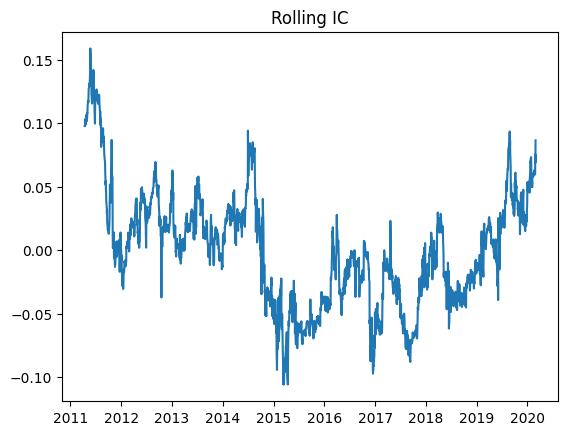

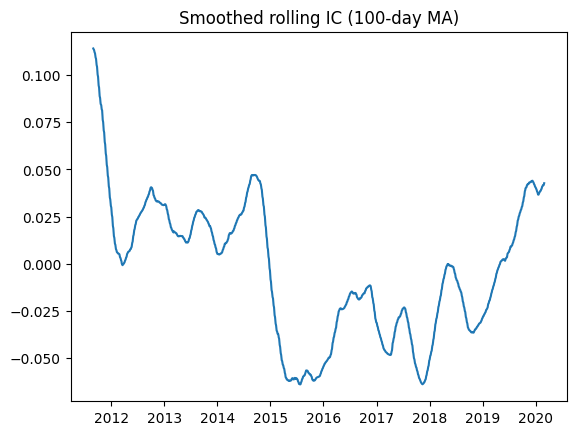

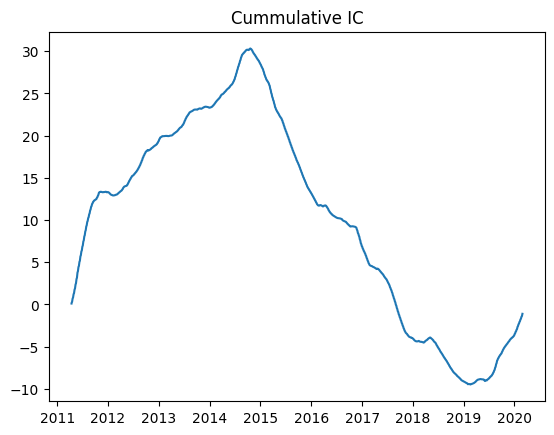

In [ ]:
def calcRollingIC(df_m_rets, df_signal, roll_window_length=252):

    roll_ics = df_rets.rolling(roll_window_length).corr(df_signal)
    print('Average rolling IC:', roll_ics.mean().round(4).item())

    plt.plot(roll_ics)
    plt.title(f'Rolling IC')
    plt.show()

    plt.plot(roll_ics.rolling(100).mean().dropna())
    plt.title('Smoothed rolling IC (100-day MA)')
    plt.show()

    plt.plot(roll_ics.cumsum().dropna())
    plt.title('Cummulative IC')
    plt.show()

    return roll_ics

roll_ics = calcRollingIC(df_m_rets, df_signal)

### 20.2.6 GARCH in Practice: Estimation of GARCH(1,1) Parameters to Equity Index Returns

In this coding example we show how to estimate the parameters in a GARCH(1,1) model:

In [ ]:
# load data
df_px1 = yf.download('SPY', start='2000-01-01', end='2010-12-31', auto_adjust=False)['Adj Close']
df_rets1 = np.log(df_px1/df_px1.shift(1)).dropna()

df_px2 = yf.download('SPY', start='2010-01-01', end='2021-12-31', auto_adjust=False)['Adj Close']
df_rets2 = np.log(df_px2/df_px2.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# calculate GARCH coefficients using arch package
garch = arch_model(df_rets1, mean='Zero', vol='GARCH', p=1, q=1)
garch_fitted = garch.fit()
print(garch_fitted)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -8547.310710078315
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8547.310723444632
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8547.31
Distribution:                  Normal   AIC:                          -17088.6
Method:            Maximum Likelihood   BIC:                          -17070.8
                                        No. Observations:                 2765
Date:                Fri, Jan 02 2026   Df Residuals:                     2765
Time:                        22:04:15   Df Model:                            0
         

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [ ]:
# calculate GARCH coefficients using arch package
garch = arch_model(df_rets2, mean='Zero', vol='GARCH', p=1, q=1)
garch_fitted = garch.fit()
print(garch_fitted)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -10116.794192928606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10116.794179302677
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                10116.8
Distribution:                  Normal   AIC:                          -20227.6
Method:            Maximum Likelihood   BIC:                          -20209.6
                                        No. Observations:                 3019
Date:                Fri, Jan 02 2026   Df Residuals:                     3019
Time:                        22:04:46   Df Model:                            0
       

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


### 20.2.10 Shrinkage in Practice: Impact on Structure of Principal Components

In this coding example we show how shrinkage can be applied to a covariance matrix. We assume a target or normalizing matrix that has constant correlation between assets, and allow a parameter which varies the amount of shrinkage applied:

In [ ]:
def covMatShrinkage(cov_mat, vols, const_corr, phi):

    N = cov_mat.shape[0]

    # make the constant correlation covariance matrix with the proper vols
    const_corr_mat = np.full((N, N), const_corr)
    np.fill_diagonal(const_corr_mat, 1.0)

    vols_mat = np.diag(vols)
    const_cov_mat = vols_mat.T @ const_corr_mat @ vols_mat

    # combine the empirical and constant correlation covariance matrix
    cov_mat_hat = (1 - phi)* cov_mat + phi * const_cov_mat                 # (20.33)

    return cov_mat_hat

In [ ]:
# example data
us_sector_etfs = [
    "XLB",  # Materials
    "XLE",  # Energy
    "XLF",  # Financials
    "XLI",  # Industrials
    "XLK",  # Technology
    "XLP",  # Consumer Staples
    "XLU",  # Utilities
    "XLV",  # Health Care
    "XLY",  # Consumer Discretionary
    "XLRE", # Real Estate
    "XLC",  # Communication Services
]
df_px = yf.download(us_sector_etfs, start='2014-03-01', end='2024-03-01', auto_adjust=False)['Adj Close']

# daily returns
df_rets = np.log(df_px/df_px.shift(1)).dropna()

# empirical covariance matrix
empirical_cov_mat = df_rets.cov()

# asset volatilities (standard deviation of returns)
vols = df_rets.std().values

print("\nEmpirical Covariance Matrix:")
display(empirical_cov_mat)

[*********************100%***********************]  11 of 11 completed


Empirical Covariance Matrix:


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000154,0.000227,0.000205,0.000193,0.000183,0.000106,0.000160,0.000125,0.000124,0.000177
XLC,0.000154,0.000231,0.000154,0.000166,0.000153,0.000223,0.000094,0.000141,0.000097,0.000119,0.000198
XLE,0.000227,0.000154,0.000495,0.000260,0.000227,0.000176,0.000103,0.000162,0.000123,0.000128,0.000174
XLF,0.000205,0.000166,0.000260,0.000260,0.000209,0.000192,0.000113,0.000171,0.000130,0.000133,0.000188
XLI,0.000193,0.000153,0.000227,0.000209,0.000208,0.000184,0.000107,0.000161,0.000125,0.000125,0.000178
XLK,0.000183,0.000223,0.000176,0.000192,0.000184,0.000289,0.000113,0.000166,0.000116,0.000146,0.000231
XLP,0.000106,0.000094,0.000103,0.000113,0.000107,0.000113,0.000110,0.000114,0.000111,0.000092,0.000101
XLRE,0.000160,0.000141,0.000162,0.000171,0.000161,0.000166,0.000114,0.000229,0.000164,0.000123,0.000161
XLU,0.000125,0.000097,0.000123,0.000130,0.000125,0.000116,0.000111,0.000164,0.000194,0.000107,0.000107


In [ ]:
# apply shrinkage
const_corr = 0.5
phi_list = np.linspace(0,1,6)
phi_list = [np.round(phi,1) for phi in phi_list]

for phi in phi_list:
    shrunk_cov_mat = covMatShrinkage(empirical_cov_mat, vols, const_corr, phi)
    print(f"\nShrunk Covariance Matrix (Phi={phi}):")
    display(shrunk_cov_mat)


Shrunk Covariance Matrix (Phi=0.0):


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000154,0.000227,0.000205,0.000193,0.000183,0.000106,0.000160,0.000125,0.000124,0.000177
XLC,0.000154,0.000231,0.000154,0.000166,0.000153,0.000223,0.000094,0.000141,0.000097,0.000119,0.000198
XLE,0.000227,0.000154,0.000495,0.000260,0.000227,0.000176,0.000103,0.000162,0.000123,0.000128,0.000174
XLF,0.000205,0.000166,0.000260,0.000260,0.000209,0.000192,0.000113,0.000171,0.000130,0.000133,0.000188
XLI,0.000193,0.000153,0.000227,0.000209,0.000208,0.000184,0.000107,0.000161,0.000125,0.000125,0.000178
XLK,0.000183,0.000223,0.000176,0.000192,0.000184,0.000289,0.000113,0.000166,0.000116,0.000146,0.000231
XLP,0.000106,0.000094,0.000103,0.000113,0.000107,0.000113,0.000110,0.000114,0.000111,0.000092,0.000101
XLRE,0.000160,0.000141,0.000162,0.000171,0.000161,0.000166,0.000114,0.000229,0.000164,0.000123,0.000161
XLU,0.000125,0.000097,0.000123,0.000130,0.000125,0.000116,0.000111,0.000164,0.000194,0.000107,0.000107



Shrunk Covariance Matrix (Phi=0.2):


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000146,0.000215,0.000188,0.000176,0.000172,0.000101,0.000151,0.000120,0.000117,0.000165
XLC,0.000146,0.000231,0.000157,0.000157,0.000144,0.000204,0.000091,0.000136,0.000099,0.000113,0.000183
XLE,0.000215,0.000157,0.000495,0.000244,0.000214,0.000179,0.000105,0.000164,0.000129,0.000128,0.000174
XLF,0.000188,0.000157,0.000244,0.000260,0.000190,0.000181,0.000107,0.000161,0.000127,0.000125,0.000176
XLI,0.000176,0.000144,0.000214,0.000190,0.000208,0.000172,0.000101,0.000151,0.000120,0.000116,0.000165
XLK,0.000172,0.000204,0.000179,0.000181,0.000172,0.000289,0.000108,0.000159,0.000116,0.000136,0.000212
XLP,0.000101,0.000091,0.000105,0.000107,0.000101,0.000108,0.000110,0.000107,0.000104,0.000086,0.000097
XLRE,0.000151,0.000136,0.000164,0.000161,0.000151,0.000159,0.000107,0.000229,0.000153,0.000116,0.000152
XLU,0.000120,0.000099,0.000129,0.000127,0.000120,0.000116,0.000104,0.000153,0.000194,0.000101,0.000108



Shrunk Covariance Matrix (Phi=0.4):


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000138,0.000203,0.000171,0.000159,0.000161,0.000095,0.000141,0.000116,0.000109,0.000153
XLC,0.000138,0.000231,0.000160,0.000148,0.000136,0.000185,0.000088,0.000131,0.000101,0.000106,0.000167
XLE,0.000203,0.000160,0.000495,0.000228,0.000201,0.000182,0.000108,0.000165,0.000136,0.000128,0.000175
XLF,0.000171,0.000148,0.000228,0.000260,0.000172,0.000170,0.000102,0.000152,0.000123,0.000117,0.000164
XLI,0.000159,0.000136,0.000201,0.000172,0.000208,0.000159,0.000095,0.000140,0.000115,0.000108,0.000152
XLK,0.000161,0.000185,0.000182,0.000170,0.000159,0.000289,0.000103,0.000151,0.000117,0.000127,0.000192
XLP,0.000095,0.000088,0.000108,0.000102,0.000095,0.000103,0.000110,0.000100,0.000096,0.000080,0.000094
XLRE,0.000141,0.000131,0.000165,0.000152,0.000140,0.000151,0.000100,0.000229,0.000141,0.000109,0.000144
XLU,0.000116,0.000101,0.000136,0.000123,0.000115,0.000117,0.000096,0.000141,0.000194,0.000096,0.000108



Shrunk Covariance Matrix (Phi=0.6):


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000129,0.000190,0.000154,0.000141,0.000149,0.000089,0.000131,0.000112,0.000101,0.000141
XLC,0.000129,0.000231,0.000163,0.000140,0.000127,0.000167,0.000085,0.000125,0.000102,0.000100,0.000151
XLE,0.000190,0.000163,0.000495,0.000212,0.000187,0.000184,0.000111,0.000166,0.000142,0.000128,0.000175
XLF,0.000154,0.000140,0.000212,0.000260,0.000153,0.000159,0.000096,0.000142,0.000120,0.000109,0.000151
XLI,0.000141,0.000127,0.000187,0.000153,0.000208,0.000147,0.000088,0.000130,0.000110,0.000100,0.000139
XLK,0.000149,0.000167,0.000184,0.000159,0.000147,0.000289,0.000099,0.000144,0.000117,0.000117,0.000173
XLP,0.000089,0.000085,0.000111,0.000096,0.000088,0.000099,0.000110,0.000093,0.000088,0.000073,0.000090
XLRE,0.000131,0.000125,0.000166,0.000142,0.000130,0.000144,0.000093,0.000229,0.000129,0.000102,0.000136
XLU,0.000112,0.000102,0.000142,0.000120,0.000110,0.000117,0.000088,0.000129,0.000194,0.000091,0.000109



Shrunk Covariance Matrix (Phi=0.8):


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000121,0.000178,0.000137,0.000124,0.000138,0.000084,0.000122,0.000108,0.000094,0.000129
XLC,0.000121,0.000231,0.000166,0.000131,0.000118,0.000148,0.000082,0.000120,0.000104,0.000094,0.000135
XLE,0.000178,0.000166,0.000495,0.000196,0.000174,0.000187,0.000114,0.000167,0.000149,0.000128,0.000175
XLF,0.000137,0.000131,0.000196,0.000260,0.000135,0.000148,0.000090,0.000132,0.000116,0.000101,0.000139
XLI,0.000124,0.000118,0.000174,0.000135,0.000208,0.000135,0.000082,0.000119,0.000105,0.000092,0.000126
XLK,0.000138,0.000148,0.000187,0.000148,0.000135,0.000289,0.000094,0.000136,0.000118,0.000108,0.000153
XLP,0.000084,0.000082,0.000114,0.000090,0.000082,0.000094,0.000110,0.000086,0.000081,0.000067,0.000086
XLRE,0.000122,0.000120,0.000167,0.000132,0.000119,0.000136,0.000086,0.000229,0.000117,0.000095,0.000127
XLU,0.000108,0.000104,0.000149,0.000116,0.000105,0.000118,0.000081,0.000117,0.000194,0.000086,0.000109



Shrunk Covariance Matrix (Phi=1.0):


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Ticker,,,,,,,,,,,
XLB,0.000221,0.000113,0.000165,0.000120,0.000107,0.000126,0.000078,0.000112,0.000103,0.000086,0.000117
XLC,0.000113,0.000231,0.000169,0.000123,0.000110,0.000129,0.000080,0.000115,0.000106,0.000088,0.000120
XLE,0.000165,0.000169,0.000495,0.000180,0.000161,0.000189,0.000117,0.000168,0.000155,0.000129,0.000175
XLF,0.000120,0.000123,0.000180,0.000260,0.000116,0.000137,0.000085,0.000122,0.000112,0.000093,0.000127
XLI,0.000107,0.000110,0.000161,0.000116,0.000208,0.000123,0.000076,0.000109,0.000100,0.000083,0.000114
XLK,0.000126,0.000129,0.000189,0.000137,0.000123,0.000289,0.000089,0.000129,0.000118,0.000098,0.000134
XLP,0.000078,0.000080,0.000117,0.000085,0.000076,0.000089,0.000110,0.000079,0.000073,0.000061,0.000082
XLRE,0.000112,0.000115,0.000168,0.000122,0.000109,0.000129,0.000079,0.000229,0.000105,0.000087,0.000119
XLU,0.000103,0.000106,0.000155,0.000112,0.000100,0.000118,0.000073,0.000105,0.000194,0.000080,0.000110


In [ ]:
# calculate explained variances at diffirent phi's
vars = []
for phi in phi_list:
    shrunk_cov_mat = covMatShrinkage(empirical_cov_mat, vols, const_corr, phi)
    eigvals, _ = linalg.eigh(shrunk_cov_mat)
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    explained_var = eigvals / eigvals.sum()
    vars.append(explained_var)

df_explained_var = pd.DataFrame(vars, columns=[f'PC{i+1}' for i in range(len(eigvals))], index=phi_list)
df_explained_var.index.name = 'Phi'
df_explained_var

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Phi,,,,,,,,,,,
0.0,0.693201,0.115660,0.072973,0.028259,0.021529,0.014927,0.013966,0.012735,0.010881,0.008979,0.006891
0.2,0.664293,0.108330,0.066852,0.033423,0.024822,0.021338,0.019787,0.019051,0.016346,0.013743,0.012016
0.4,0.635807,0.101293,0.060865,0.038069,0.029406,0.027758,0.026311,0.025258,0.020738,0.019715,0.014780
0.6,0.607820,0.094722,0.055253,0.042001,0.035930,0.033754,0.032381,0.030870,0.027329,0.022566,0.017374
0.8,0.580421,0.088906,0.051298,0.044643,0.042854,0.039564,0.038192,0.035574,0.033942,0.024824,0.019782
1.0,0.553718,0.084273,0.053713,0.048801,0.046121,0.043923,0.042680,0.040482,0.037702,0.026784,0.021803


<Axes: >

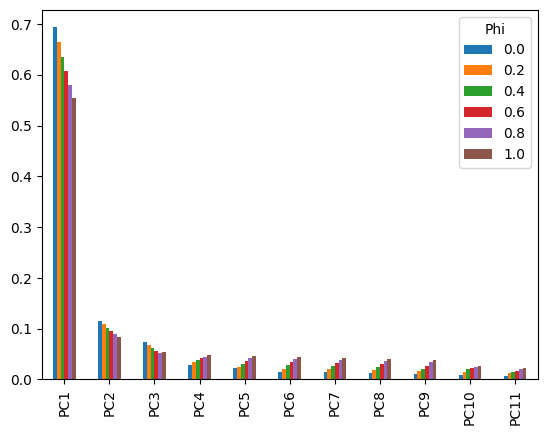

In [ ]:
# visualization
df_explained_var.T.plot.bar()